In [7]:
import os.path as op
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

bids_folder = '/mnt_03/ds-dnumrisk' #'/Users/mrenke/data/ds-dnumrisk'
subjects = [int(f[4:]) for f in os.listdir(bids_folder) if f[0:3] == 'sub' and len(f) == 6]
base = 'decoding.2d.mixture.same_rfs'

target_folder = '/Users/mrenke/data/ds-dnumrisk/derivatives/phenotype'

from numrisk.utils.data import get_data_magjduge
df = get_data_magjduge(bids_folder=bids_folder)
df['log(n2)'] = np.log(df['n2'])

number of subjects found: 66


In [8]:
from utils import get_decoding2D_info

pred = []
for sub in subjects:
    try: 
        Es = get_decoding2D_info(sub,bids_folder=bids_folder, key = base)
        pred.append(Es)
    except:
        print('problems: sub-'+ str(sub))
        
pred = pd.concat(pred).join(df, how='inner') 


problems: sub-21
problems: sub-3


In [9]:
pred.head()

E_n1      E_n2        rt    n1    n2  choice  \
subject run trial_nr                                                     
59      1   1         3.116958  3.195212  2.657239  14.0  21.0    True   
            2         3.280574  3.333290  3.223939   7.0   6.0   False   
            3         3.401790  3.452518  1.555000  14.0   9.0   False   
            4         2.477778  2.716398  1.238032  10.0   7.0   False   
            5         2.820295  3.055266  1.171485  10.0   5.0   False   

                      chose_n2      frac  log(n2/n1)   log(n1)  group  \
subject run trial_nr                                                    
59      1   1             True  1.500000    0.405465  2.639057      0   
            2            False  0.857143   -0.154151  1.945910      0   
            3            False  0.642857   -0.441833  2.639057      0   
            4            False  0.700000   -0.356675  2.302585      0   
            5            False  0.500000   -0.693147  2.302585      0   

                       log(n2)  
subject run trial_nr            
59      1   1         3.044522  
            2         1.791759  
            3         2.197225  
            4         1.945910  
            5         1.609438

In [10]:
import pingouin as pg

r_n1 = pred.groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E_n1'], d['log(n1)']))
r_n2 = pred.groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E_n2'], d['log(n2)']))


/tmp/ipykernel_2021663/2648226986.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r_n1 = pred.groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E_n1'], d['log(n1)']))
/tmp/ipykernel_2021663/2648226986.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r_n2 = pred.groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E_n2'], d['log(n2)']))


In [12]:
r_n1

,,,n,r,CI95%,p-val,BF10,power
subject,group,,,,,,,
1,0,pearson,180,0.022525,"[-0.12, 0.17]",0.764073,0.098,0.060312
2,1,pearson,173,0.032812,"[-0.12, 0.18]",0.668239,0.104,0.071243
4,1,pearson,178,-0.105242,"[-0.25, 0.04]",0.162082,0.247,0.288331
5,0,pearson,179,-0.009486,"[-0.16, 0.14]",0.899714,0.094,0.051735
6,1,pearson,180,-0.014903,"[-0.16, 0.13]",0.842603,0.095,0.054448
...,...,...,...,...,...,...,...,...
62,0,pearson,179,0.079305,"[-0.07, 0.22]",0.291308,0.162,0.184413
63,0,pearson,178,-0.070746,"[-0.22, 0.08]",0.348041,0.145,0.155573
64,0,pearson,178,0.112561,"[-0.04, 0.26]",0.134672,0.285,0.322616


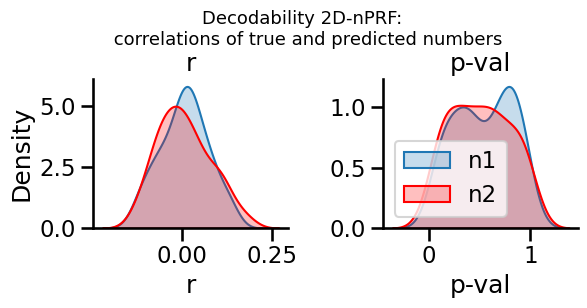

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))  # Adjust figsize as needed
sns.kdeplot(r_n1, x='r', fill=True, label='n1', ax=axes[0])
sns.kdeplot(r_n2, x='r', fill=True, label='n2', color='red', ax=axes[0])
axes[0].set_title('r')  # Optional title for first subplot
sns.kdeplot(r_n1, x='p-val', fill=True, label='n1', ax=axes[1])
sns.kdeplot(r_n2, x='p-val', fill=True, label='n2', color='red', ax=axes[1])
axes[1].legend()  # Add legend to the second subplot
axes[1].set(title="p-val",ylabel=None)  # Optional title for second subplot
plt.tight_layout()
sns.despine()
fig.suptitle(f'Decodability 2D-nPRF: \n correlations of true and predicted numbers',fontsize=13, y=1.05)
plt.subplots_adjust()
plt.show()

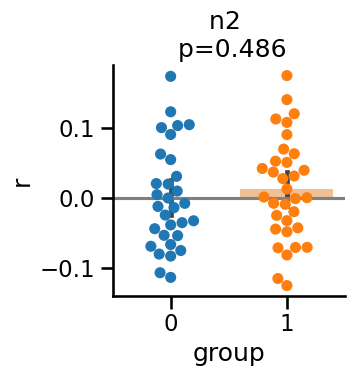

In [42]:
n = 'n2'
temp = r_n2#.groupby(['subject','group']).mean()
sns.set_context('talk')

y_var = 'r'
an = pg.anova(data=temp.reset_index(), dv=y_var, between='group')
p_val = np.round(an['p-unc'][0],3)

fig, ax = plt.subplots(figsize=(3,3))
sns.barplot(ax=ax,data=temp.reset_index(), x='group', y=y_var,  hue='group', alpha=0.5,legend=False)
sns.swarmplot(ax=ax, data=temp.reset_index(), x='group', y=y_var,  hue='group',size=8,legend=False)
ax.set(title=f'{n} \n p={p_val}') # ylim=(0.5,1),
plt.axhline(0,color='grey')
sns.despine()